In [2]:
!nvidia-smi

Wed Sep 27 13:19:43 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.26                 Driver Version: 375.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0     Off |                  N/A |
|  0%   33C    P8    14W / 200W |      0MiB /  8113MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:03:00.0     Off |                  N/A |
|  0%   33C    P8    14W / 200W |      0MiB /  8112MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [1]:
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np
import sys
import os

sys.path.append(os.path.join("..", "..", ".."))
import ecg.dataset as ds
from ecg.batch import ModelEcgBatch

%env CUDA_VISIBLE_DEVICES=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
config.gpu_options.allow_growth=True

Using TensorFlow backend.


env: CUDA_VISIBLE_DEVICES=0


## Train pipeline

In [ ]:
config_tr = {'path': "/notebooks/e_illarionov/ecg_repo/model_dump/triplet_latest",
             'out_layer': -43}

conv_train_pipeline = (ds.Pipeline(config={'triplet_embedding': config_tr})
                         .init_model('triplet_embedding')
                         .load(fmt="wfdb", components=["signal", "meta"])
                         .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                               fmt="csv", components="target")
                         .drop_labels(["~"])
                         .replace_labels({"N": "NO", "O": "NO"})
                         .split_signals(3000, 3000)
                         .binarize_labels()
                         .ravel()
                         .tile(3)
                         .signal_transpose([2, 1, 0])
                         .predict_on_batch('triplet_embedding', inplace=True)
                         .slice_signal(slice(1))
                         .apply(np.squeeze, axis=0)
#                          .squeeze(axis=0)
                         .train_on_batch('conv_model', metrics=f1_score, average='macro')
                         .run(batch_size=300, shuffle=True,
                              drop_last=True, n_epochs=1, prefetch=0, lazy=True))

In [ ]:
index = ds.FilesIndex(path="/notebooks/data/ECG/training2017/*.hea", no_ext=True, sort=True)
eds = ds.Dataset(index, batch_class=ModelEcgBatch)
eds.cv_split(0.8)
conv_trained = (eds.train >> conv_train_pipeline).run()

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Show loss and metric on train

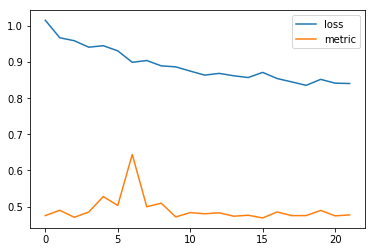

In [5]:
plt.plot(conv_trained.get_model_by_name('conv_model').hist['train_loss'], label='loss')
plt.plot(conv_trained.get_model_by_name('conv_model').hist['train_metric'], label='metric')
plt.legend()
plt.show()

## Save model

In [20]:
(conv_trained.get_model_by_name("conv_model")
             .save("/notebooks/e_illarionov/ecg_repo/model_dump/conv_latest"))

## Test pipeline

In [21]:
conv_test_pipeline = (ds.Pipeline(config={'triplet_embedding': config_tr})
                      .init_model('triplet_embedding')
                      .load(fmt="wfdb", components=["signal", "meta"])
                      .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                            fmt="csv", components="target")
                      .drop_labels(["~"])
                      .replace_labels({"N": "NO", "O": "NO"})
                      .split_signals(3000, 3000)
                      .binarize_labels()
                      .ravel()
                      .tile(3)
                      .signal_transpose([2, 1, 0])
                      .predict_on_batch('triplet_embedding', inplace=True)
                      .slice_signal(slice(1))
                      .squeeze(axis=0)
                      .test_on_batch('conv_model', metrics=f1_score, average='macro')
                      .run(batch_size=300, shuffle=True,
                           drop_last=True, n_epochs=1, prefetch=0, lazy=True))

In [22]:
res_test = (eds.test >> conv_test_pipeline).run()

## Show loss and metric on test


In [23]:
print(np.mean(res_test.get_model_by_name('conv_model').hist['val_loss']))
print(np.mean(res_test.get_model_by_name('conv_model').hist['val_metric']))

0.913874
0.133995741668


## Predict pipeline

In [32]:
config_cv = {'path': "/notebooks/e_illarionov/ecg_repo/model_dump/conv_latest"}

conv_predict_pipeline = (ds.Pipeline(config={'triplet_embedding': config_tr,
                                             'conv_pretrained': config_cv})
                         .init_model('triplet_embedding')
                         .init_model('conv_pretrained')
                         .init_variable("prediction", init=list)
                         .load(fmt="wfdb", components=["signal", "meta"])
                         .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                               fmt="csv", components="target")
                         .drop_labels(["~"])
                         .replace_labels({"N": "NO", "O": "NO"})
                         .split_signals(3000, 3000)
                         .binarize_labels()
                         .ravel()
                         .tile(3)
                         .signal_transpose([2, 1, 0])
                         .predict_on_batch('triplet_embedding', inplace=True)
                         .slice_signal(slice(1))
                         .squeeze(axis=0)
                         .predict_on_batch('conv_model')
                         .run(batch_size=100, shuffle=False, drop_last=False,
                              n_epochs=1, prefetch=0, lazy=True))

In [33]:
res_predict = (eds.test >> conv_predict_pipeline).run()

In [34]:
res_predict.get_variable('prediction')

[array([[ 0.40074655,  0.59925348],
        [ 0.41847068,  0.58152938],
        [ 0.41781309,  0.58218694],
        [ 0.446174  ,  0.55382603],
        [ 0.39703551,  0.60296452],
        [ 0.47490487,  0.52509505],
        [ 0.43629926,  0.56370074],
        [ 0.44953063,  0.55046934],
        [ 0.4357028 ,  0.56429714],
        [ 0.42543304,  0.5745669 ],
        [ 0.41097608,  0.58902389],
        [ 0.4791896 ,  0.52081043],
        [ 0.40603963,  0.59396034],
        [ 0.42633885,  0.57366115],
        [ 0.43644992,  0.56355006],
        [ 0.44326264,  0.55673736],
        [ 0.46833739,  0.53166264],
        [ 0.43753916,  0.56246084],
        [ 0.40023789,  0.59976214],
        [ 0.40521049,  0.59478945],
        [ 0.40867433,  0.59132564],
        [ 0.44283137,  0.5571686 ],
        [ 0.45137763,  0.54862243],
        [ 0.5041095 ,  0.49589053],
        [ 0.41116706,  0.58883297],
        [ 0.45048881,  0.54951119],
        [ 0.40534875,  0.59465122],
        [ 0.42546156,  0.574